# Neural Networks III: Improving Generalization

Until now, we have focused on how to build and train neural network models that fit the training data.

We have also seen that neural networks are incredibly powerful — capable of fitting **any function**. However, this flexibility comes with a downside: they are prone to **overfitting**, especially as we increase the number of hidden layers or model complexity.

In this lesson, we will introduce several key techniques to improve **generalization** — most often by mitigating overfitting — in neural networks. 

By the end of this lesson, you should be able to understand and implement these tecniques in `PyTorch`, including:

- Early stopping
- Dropout
- L2 Regularization (Weight Decay)
- Batch normalization

## 1. Early Stopping

If you let neural networks train for too long, their ability to generalize to unseen data may start to **deteriorate** — a classic symptom of **overfitting**.

One way to prevent this is to **stop the training process as soon as performance on a validation set begins to degrade**. This is the core idea behind the **Early Stopping** criterion.

Early stopping is a widely adopted and effective regularization technique in practice.

In [1]:
import torch
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X, y = load_digits()["data"], load_digits()["target"]
X = torch.tensor(X / 16.0, dtype=torch.float32)
y = torch.tensor(y.astype(int), dtype=torch.long)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=100, train_size=400, stratify=y)

# Define batch size
batch_size = 64

# Wrap the data in a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [2]:
from torch import nn

# Let's create this simple neural network
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [3]:
from torch import optim

torch.manual_seed(123)

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train and track losses
n_epochs = 500
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    y_pred = model(X_train)
    train_loss = loss_fn(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = loss_fn(y_val_pred, y_val)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

Let's calculate the performance of our model on the training and validation set.

Remember, our output layer contains 10 units, one for each class. 

In [4]:
model.eval()
with torch.no_grad():
    print(model(X_val[0]))

tensor([ -3.2240,  -0.8138, -10.9647,  -8.8202,   3.3470,  11.4630,   0.4512,
          4.2917,   1.1406,  -7.3927])


Softmax in the cross-entropy cost function would convert this into probabilities for each classs. Thefore, we just need to take that unit with the highest value as our output label, since this will be our most likely class.

In [5]:
with torch.no_grad():
    output = model(X_val[0])
    probs = nn.Softmax(dim=0)(model(X_val[0]))
    print("output: ", output.numpy()) 
    print("probs: ", probs.numpy()) 
    print(torch.argmax(probs), torch.argmax(model(X_val[0])))

output:  [ -3.2239833   -0.81376195 -10.964694    -8.820165     3.3470209
  11.462971     0.45123553   4.2917433    1.1405838   -7.3927445 ]
probs:  [4.1787834e-07 4.6536748e-06 1.8167773e-10 1.5511714e-09 2.9840152e-04
 9.9887961e-01 1.6488359e-05 7.6751813e-04 3.2851676e-05 6.4651746e-09]
tensor(5) tensor(5)


In [6]:
from sklearn.metrics import accuracy_score

model.eval()
with torch.no_grad():  # No gradient tracking

    y_train_pred = torch.argmax(model(X_train), dim=1)
    y_val_pred = torch.argmax(model(X_val), dim=1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_val = accuracy_score(y_val, y_val_pred)

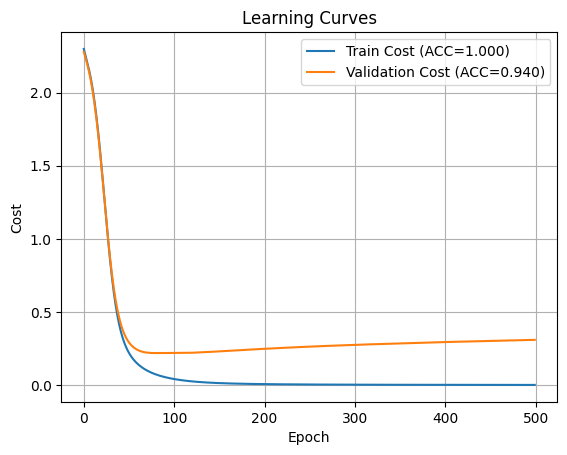

In [7]:
import matplotlib.pylab as plt

# 6. Plot the training and validation loss
plt.plot(train_losses, label=f"Train Cost (ACC={acc_train:.3f})")
plt.plot(val_losses, label=f"Validation Cost (ACC={acc_val:.3f})")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

As you see, near 100 epochs our validation costs starts to grow. Ideally, we would like our neural network to stop right there.

### Implementation

`PyTorch` does not include an implementation for EarlyStopping, but it is not hard to do it. Here below you have one recipe generated by LLM: 

In [8]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_weights(self, model):
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)

This seems complicated. Other libraries such as `scikit-learn` or `Keras` already implement this criterion.

However, by implementing it yourselves, you know how it works internally -- so you gain an important intuition!

In [9]:
early_stopping = EarlyStopping(patience=5)

torch.manual_seed(123)

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train and track losses
n_epochs = 500
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    y_pred = model(X_train)
    train_loss = loss_fn(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = loss_fn(y_val_pred, y_val)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print(f"Stopping early at epoch {epoch+1}")
        break

early_stopping.restore_best_weights(model)

Stopping early at epoch 87


In [10]:
model.eval()
with torch.no_grad():  # No gradient tracking

    y_train_pred = torch.argmax(model(X_train), dim=1)
    y_val_pred = torch.argmax(model(X_val), dim=1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_val = accuracy_score(y_val, y_val_pred)

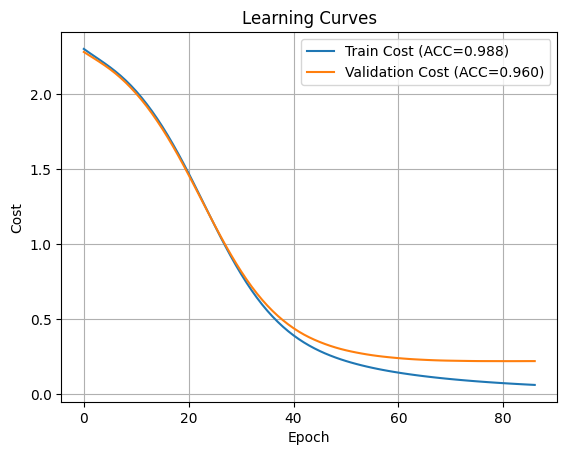

In [11]:
# 6. Plot the training and validation loss
plt.plot(train_losses, label=f"Train Cost (ACC={acc_train:.3f})")
plt.plot(val_losses, label=f"Validation Cost (ACC={acc_val:.3f})")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

## 2. Dropout

One effective technique to prevent overfitting is randomly deactivating neurons (units) during training. This is the main idea behind **dropout**.

Dropout forces the model to not rely too heavily on any single neuron; instead, it encourages the network to learn more robust and distributed patterns.

It is typically applied to the hidden layers of the network. You can apply dropout to one layer or to multiple layers, depending on the model's complexity and your regularization needs.

This technique is so effective that most modern neural networks include some form of dropout by default.

### Implementation

In `PyTorch`, dropout is implemented as a type of layer — because conceptually, it acts as a transformation applied to the activations of a layer. Specifically, it randomly sets a subset of the units to zero during training.

We will typically use `nn.Dropout`. But you cand find more types in the [dropout-layers documentation](https://docs.pytorch.org/docs/stable/nn.html#dropout-layers).

<div class="alert alert-block alert-info">

**NOTE**  
Dropout is active **only during training**. When calling `model.eval()`, dropout is automatically disabled.  
That is why we have been using `model.eval()` consistently when evaluating performance on the validation or test set.

</div>


In [12]:
class MLPwDropOut(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2) # p is the probability of randomly setting to zero some of the elements of the input tensor

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x) # Apply to the first hidden layer
        x = self.relu(self.fc2(x))
        x = self.dropout(x) # Apply to the second hidden layer
        x = self.fc3(x)
        #x = self.sigmoid(self.fc3(x))
        return x

In [13]:
early_stopping = EarlyStopping(patience=5)

torch.manual_seed(123)

model = MLPwDropOut()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train and track losses
n_epochs = 500
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    y_pred = model(X_train)
    train_loss = loss_fn(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = loss_fn(y_val_pred, y_val)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print(f"Stopping early at epoch {epoch+1}")
        break

early_stopping.restore_best_weights(model)

Stopping early at epoch 91


In [14]:
model.eval()
with torch.no_grad():  # No gradient tracking

    y_train_pred = torch.argmax(model(X_train), dim=1)
    y_val_pred = torch.argmax(model(X_val), dim=1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_val = accuracy_score(y_val, y_val_pred)

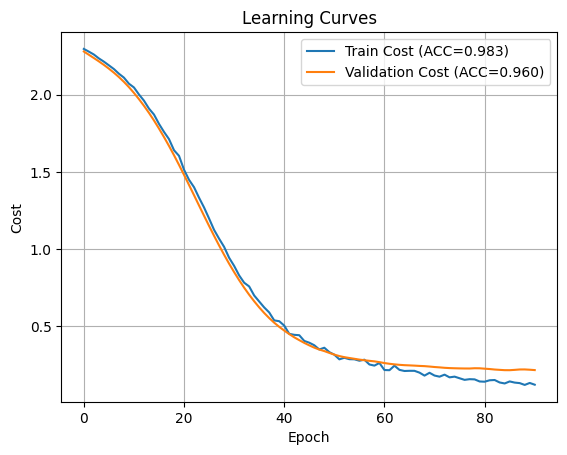

In [15]:
# 6. Plot the training and validation loss
plt.plot(train_losses, label=f"Train Cost (ACC={acc_train:.3f})")
plt.plot(val_losses, label=f"Validation Cost (ACC={acc_val:.3f})")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

Notice how adding dropout slightly reduced training accuracy, but validation accuracy stayed the same. That is actually a good thing — it means the model is not just memorizing the training data, but learning patterns that generalize better. Dropout helped reduce overfitting.

## 3. L2 Regularization (Weight Decay)

L2 regularization adds a penalty to the loss function for large weights, which, as you know, helps prevent overfitting and in many cases improve the generalization of the model. This is also known as **weight decay**.

### Implementation

In `PyTorch`, this regularization is commonly applied globally through the optimizer — but the idea is the same: penalize large weights to prevent overfitting.


> optimizer = optim.Adam(model.parameters(), **weight_decay=1e-5**)


In other libraries such as `Keras`, L2 penalties are typically attached directly to individual layers. For more details, you can refer to [Keras's documentation](https://keras.io/api/layers/regularizers).

In [16]:
early_stopping = EarlyStopping(patience=5)

torch.manual_seed(123)

model = MLPwDropOut()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

# Train and track losses
n_epochs = 500
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    y_pred = model(X_train)
    train_loss = loss_fn(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = loss_fn(y_val_pred, y_val)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print(f"Stopping early at epoch {epoch+1}")
        break

early_stopping.restore_best_weights(model)

Stopping early at epoch 91


In [17]:
model.eval()
with torch.no_grad():  # No gradient tracking

    y_train_pred = torch.argmax(model(X_train), dim=1)
    y_val_pred = torch.argmax(model(X_val), dim=1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_val = accuracy_score(y_val, y_val_pred)

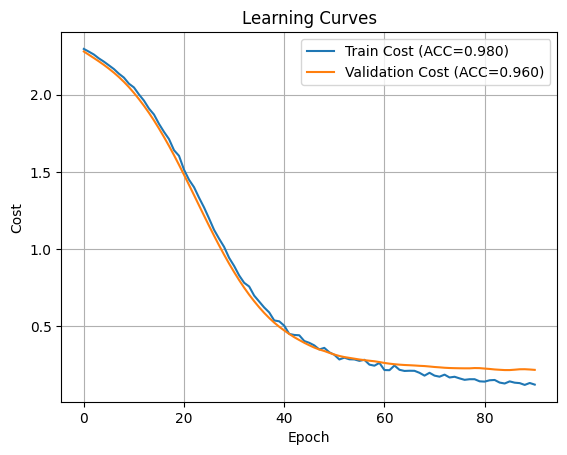

In [18]:
# 6. Plot the training and validation loss
plt.plot(train_losses, label=f"Train Cost (ACC={acc_train:.3f})")
plt.plot(val_losses, label=f"Validation Cost (ACC={acc_val:.3f})")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

---
💡 **Quick Exercise**

With regularization, more is not always better.

Try setting `weight_decay=1e-3` in the optimizer. What do you observe in terms of training and validation performance? Why do you think this happens? (*Hint*: What is the effect of penalizing large weights too strongly? How might that impact the model’s ability to fit the training data?)


In [19]:
# YOUR CODE

---

## 4. Batch Normalization

Batch normalization standardizes the inputs to each layer by subtracting the batch mean and dividing by the batch standard deviation.

**This helps stabilize and accelerate training, and often acts as a form of mild regularization.**

### Implementation

In `PyTorch`, you can just insert `nn.BatchNorm1d(n_units)` after a linear layer and before the activation:

>
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.relu(x)


In [20]:
class MLPwDropOutAndBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2) 
        self.bn1 = nn.BatchNorm1d(200)
        self.bn2 = nn.BatchNorm1d(200)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x) # We apply the first batch normalization after the first linear transformation
        x = self.relu(x)
        x = self.dropout(x) 
        x = self.fc2(x)
        x = self.bn2(x) # We apply the second batch normalization after the second linear transformation
        x = self.relu(x)
        x = self.dropout(x) 
        x = self.fc3(x)
        
        return x

<div class="alert alert-block alert-warning">

🚨⚠️ **CAUTION** 🚨⚠️

You must use separate `BatchNorm1d` layers, even if all linear layers have the same number of units, as in our example.

`BatchNorm1d` computes statistics (mean and standard deviation) from the activations of each specific layer in the network. If you reuse the same `BatchNorm1d` instance, you would be applying the **same normalization statistics across multiple layers**, which is incorrect.

Think of each `BatchNorm1d` as being tied to the specific context of the layer it follows — not just the shape. Just like you would not reuse the same Linear(200, 200) layer twice, even if it has the same shape, you should not reuse the same BatchNorm layer either.

</div>

In [21]:
early_stopping = EarlyStopping(patience=5)

torch.manual_seed(123)

model = MLPwDropOutAndBatchNorm()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

# Train and track losses
n_epochs = 500
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    y_pred = model(X_train)
    train_loss = loss_fn(y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = loss_fn(y_val_pred, y_val)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print(f"Stopping early at epoch {epoch+1}")
        break

early_stopping.restore_best_weights(model)

Stopping early at epoch 97


In [22]:
model.eval()
with torch.no_grad():  # No gradient tracking

    y_train_pred = torch.argmax(model(X_train), dim=1)
    y_val_pred = torch.argmax(model(X_val), dim=1)

acc_train = accuracy_score(y_train, y_train_pred)
acc_val = accuracy_score(y_val, y_val_pred)

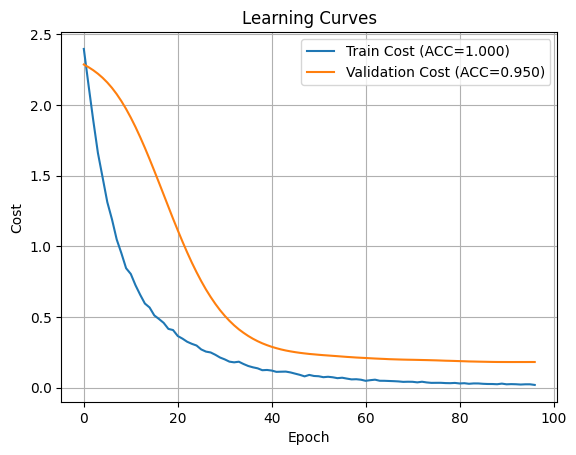

In [23]:
# 6. Plot the training and validation loss
plt.plot(train_losses, label=f"Train Cost (ACC={acc_train:.3f})")
plt.plot(val_losses, label=f"Validation Cost (ACC={acc_val:.3f})")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

As you can see, batch normalization helped our model fit the training data perfectly. But it also seems to have reduced generalization a bit. Why?

Because while it stabilizes training and speeds up learning, it does not directly prevent overfitting — and in some cases, it can overpower other forms of regularization like dropout or L2.

This is a great reminder that these tools are **not silver bullets**. They need to be **balanced and tuned together**.

---

💡 **Quick Exercise**

After adding `BatchNorm1d` layers to the model, you may notice that the training accuracy reaches 100%, while validation accuracy decreases slightly.

Try adjusting:

- The **dropout rate** (e.g., increase from `0.2` to `0.5`, or reduce to `0.1`)
- The **L2 penalty** via `weight_decay` (e.g., try `1e-4` instead of `1e-5`)

Can you find a setting that restores or improves validation performance without sacrificing too much training accuracy?

Why do you think BatchNorm makes the model overfit more easily, even though it helps with convergence?


In [24]:
# YOUR CODE

---

## 5. Summary and Looking Ahead: Deep Learning

In this module, we have learned how to build and train simple neural networks.

In this final lesson, we focused on **helping those models generalize** — using:

- **Early stopping** to avoid overtraining.
- **Dropout** to reduce over-represanting the training.
- **L2 regularization** to constrain weights.
- **Batch Normalization** to stabilize and accelerate learning.

These techniques are not only useful for small, shallow networks. They are also **essential building blocks** for training **deep neural networks**, which can have dozens or even hundreds of layers.

For example:

- Batch Normalization was a key breakthrough that made deep learning practical.
- Dropout is still used in large-scale models such as transformers.
- Weight decay remains a core part of most modern optimizer setups.

If you decide to follow the analytics concentration in our program, you will explore these ideas more deeply in future courses.

In fact, many of the challenges in deep learning are simply **extensions of what you have already seen**: making models that are expressive, efficient, and able to generalize to new data.

On top of that, you have learned all of this using **PyTorch**, which not only helped build your intuition around how neural networks work internally, but also prepares you for the coding aspects of more advanced courses in the deep learning space.

## 📝 6. Exercises

### 6.1 Exercise — Replicate on a regression task

You will now apply the same techniques for a regression task, specifically, to predict housing prices from features like location, income, and population.

Given the dataset below, you should:

- Convert the training and validation data as `DataLoader` objects to facilitate training.
- Build a fully connected neural network with **at least two hidden layers**. 
- Try adding **dropout**, **L2 regularization**, and **batch normalization**
- Try using **early stopping** to prevent overfitting.
- Compare training and validation performance. You could do this
- Plot the predicted vs. true values for the validation set.

What happens when you remove dropout or batch normalization?  How does tuning `weight_decay` affect performance?

**Remember**: This a regression problem. That will affect the output layer, the choice of the cost function and the performance metrics.

In [25]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# YOUR CODE